# Convolution - IMDB_reviews

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import tensorflow_datasets as tfds
imdb, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

## Getting Data ready

In [4]:
train, test = imdb['train'], imdb['test'] # Getting Train and Test sets

In [5]:
# Let's now take a look at 2 items in train
for i in train.take(2):
    print(i)

(<tf.Tensor: shape=(163,), dtype=int64, numpy=
array([  62,   18,   41,  604,  927,   65,    3,  644, 7968,   21,   35,
       5096,   36,   11,   43, 2948, 5240,  102,   50,  681, 7862, 1244,
          3, 3266,   29,  122,  640,    2,   26,   14,  279,  438,   35,
         79,  349,  384,   11, 1991,    3,  492,   79,  122,  188,  117,
         33, 4047, 4531,   14,   65, 7968,    8, 1819, 3947,    3,   62,
         27,    9,   41,  577, 5044, 2629, 2552, 7193, 7961, 3642,    3,
         19,  107, 3903,  225,   85,  198,   72,    1, 1512,  738, 2347,
        102, 6245,    8,   85,  308,   79, 6936, 7961,   23, 4981, 8044,
          3, 6429, 7961, 1141, 1335, 1848, 4848,   55, 3601, 4217, 8050,
          2,    5,   59, 3831, 1484, 8040, 7974,  174, 5773,   22, 5240,
        102,   18,  247,   26,    4, 3903, 1612, 3902,  291,   11,    4,
         27,   13,   18, 4092, 4008, 7961,    6,  119,  213, 2774,    3,
         12,  258, 2306,   13,   91,   29,  171,   52,  229,    2, 1245,
    

The training set is already tokenized; Tokenizer comes along with "with_info" return.

In [6]:
tokenizer = info.features['text'].encoder

In [7]:
print(f'Length of training set is {len(train)}')
print(f'Length of test set is {len(test)}')

Length of training set is 25000
Length of test set is 25000


## Prepration

In [8]:
buffer = 10000
batch = 64
train_dataset = train.shuffle(buffer)

# Batch
train_dataset = train_dataset.padded_batch(batch)
test_dataset = test.padded_batch(batch)

## Model

In [9]:
embedding_dim = 64
lstm_dim = 64

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          523840    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         41088     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 573,249
Trainable params: 573,249
Non-trainable params: 0
________________________________________________

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
epochs = 10
with tf.device('GPU:0'):
    history = model.fit(train_dataset, epochs=epochs, validation_data=(test_dataset))

Epoch 1/10
391/391 [==============================] - 113s 282ms/step - loss: 0.4401 - accuracy: 0.7911 - val_loss: 0.3071 - val_accuracy: 0.8767
Epoch 2/10
391/391 [==============================] - 55s 140ms/step - loss: 0.2185 - accuracy: 0.9186 - val_loss: 0.3019 - val_accuracy: 0.8770
Epoch 3/10
391/391 [==============================] - 36s 91ms/step - loss: 0.1694 - accuracy: 0.9395 - val_loss: 0.3306 - val_accuracy: 0.8718
Epoch 4/10
391/391 [==============================] - 27s 70ms/step - loss: 0.1352 - accuracy: 0.9525 - val_loss: 0.3832 - val_accuracy: 0.8656
Epoch 5/10
391/391 [==============================] - 25s 63ms/step - loss: 0.1093 - accuracy: 0.9620 - val_loss: 0.4196 - val_accuracy: 0.8632
Epoch 6/10
391/391 [==============================] - 19s 49ms/step - loss: 0.0851 - accuracy: 0.9716 - val_loss: 0.5001 - val_accuracy: 0.8596
Epoch 7/10
391/391 [==============================] - 16s 40ms/step - loss: 0.0669 - accuracy: 0.9788 - val_loss: 0.5808 - val_accura

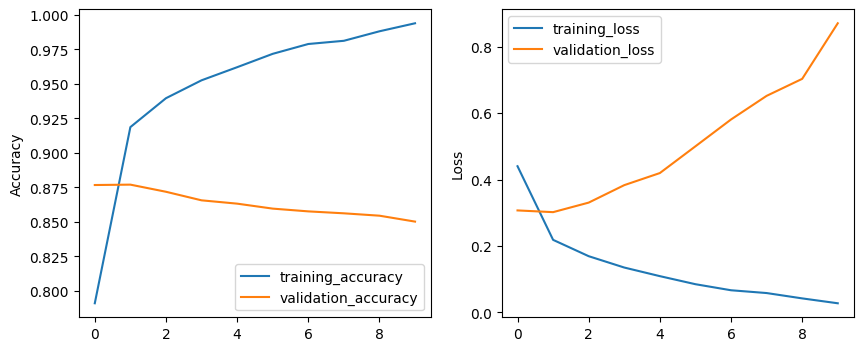

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(history.history['accuracy'], label='training_accuracy');
ax[0].plot(history.history['val_accuracy'], label='validation_accuracy');

ax[1].plot(history.history['loss'], label='training_loss')
ax[1].plot(history.history['val_loss'], label='validation_loss')

ax[0].set_ylabel('Accuracy');
ax[1].set_ylabel('Loss');

ax[0].legend();
ax[1].legend();

**This shows that we have overfitting**